addition to the code: 
1) fullfilled export the count how often which transition happens
2) read in a single/ few data sets and read all datasets

In [40]:
#to make the plot in the notebook and not in an extra window
%matplotlib notebook 

import csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
import glob, os
import re

error_on_missing_timestamps = False
error_on_time_light_mismatch = False
error_on_time_behavior_mismatch = False
error_on_missing_behaviors = False
error_on_invalid_behavior_range = False

In [41]:
#Open multiple .csv from single directory

#directory for behavior data
behavior_directory = r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/behavior_csv/' # directory for behavioral annotations
behavior_files = glob.glob(os.path.join(behavior_directory, "*.csv")) #join pathname with filename

# Behavior columns available in CSV files
available_behaviors = ('fw', 'bw', 'stim', 'hunch', 'turn', 'other', 'HP', 'left turn', 'right turn')

#regular expression (define the expression filenames are searched for)
#'.' single character, matched everything, '*' 0>> occurences, '/' path delimiter, '\d' 0-9 digit,
#'+' 1>> occurences, 'L' here character from filename
#() outcome here: 2 groups, useful for extraction
#[] optional list, eg 1 --> 1
#? character non or once 

#Behavior reg-ex (regular expression)
behavior_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-behavior-(.+).csv')

# Function: readall_behavior iterates through all csv (sorted) 
# and appends the files into the list (ls) and returns dictionary
def readall_behavior(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample (cl (closeloop), ol (openloop), blocks (Raghav))
        # Larva ID: YY-MM-DDLX
        #look for filename_components, which are true for pattern
        match = behavior_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, exp_id = filename_components #define filename_components sample_id (first group), and exp_id (sec group)
        
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ';')
        df.fillna(0, inplace=True) #replace NaN with zero
        df['sample_id'] = sample_id  #add sample_id column
        df['exp_id'] = exp_id #add exp_id column
        data[sample_id] = df
        #Count 'True' for each column ('behavior') in each single behavior.csv)
        #print(filename, df[df == 1].count()) 
        #print(df)
    return data

behavior_data = readall_behavior(behavior_files)
#print(behavior_data['17-11-27L3-cl'])

      

In [42]:
#check behavior.csv and identify how often a single behavior happened
#using the returned 'ls' from the function readAll: concatenate the 'behavior_files' (global variable) 
#sorting has to be = False (warning message without 'sort')
df_behavior = pd.concat(behavior_data.values(), axis = 0, ignore_index = True, sort = False) #add sorting
#print(df_behavior) 
#print a certain column
#print(df_behavior['hunch'])

#Print 'True' for each column ('behavior_type') in the concatenated file (df_behavior)
print(df_behavior[df_behavior == 1].count()) 

START           11
END              0
fw            5120
bw             891
stim           357
hunch          428
turn          2124
other          181
HP             776
left turn     1065
right turn    1060
sample_id        0
exp_id           0
dtype: int64


In [43]:
#Fluorescence data
#open LM files (several LM files for the same sample_id exists, differ in cell_id)
#list of LM data with two extra columns: sample_id (=behavior_files) and cell_id

    #Mapping of sampleID vs lists of LM dataframes
    #convert list to a single dataframe
    #map with df_behavior (later done)

#open LM files from different directories
lightmicroscope_directories = [r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/Basin_traces/', 
                               r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/Handle-like_Traces',
                               r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/a00c_traces'
                              ] 

#iterate through LM data and extend files in a list from within and between directory and 
#build a list of files from all directories
#(note: append would 'extend' lists and not single files)
lightmicroscope_files = []
for d in lightmicroscope_directories:
    lightmicroscope_files.extend(
        glob.glob(os.path.join(d, "*.csv"))) #join pathname with filename, 
                                                                       
#regular expression (define the expression filenames are searched for)
#'.' single character, matched everything, '*' 0>> occurences, '/' path delimiter, '\d' 0-9 digit,
#'+' 1>> occurences, 'L' here character from filename
#() outcome here: 2 groups, useful for extraction

#lightmicroscopic data reg-ex (regular expression)
lightmicroscope_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-(.*)-(.*).csv')

#Function: readall_lm iterates through all LM_csv (sorted) 
                #and returns a dictionary{key:value}??, 
#samples = {sample_id:cell-id}
def readall_lm(all_files):
    samples = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # Larva ID: YY-MM-DDLX, DETAIL = cell_id
        #look for filename_components, which are true for pattern
        match = lightmicroscope_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, cell_id, exp_id = filename_components
        
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        #read LM.files 
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ',')
        #replace NaN with zero
        df.fillna(0, inplace=True)
        
        #add cellname to each column as prefix
        #lambda is a non defined function (longer version: def lambda(x):)
        #rename of columns after the format cell_id, name) eg: Basin A9
        #inplace = True: column names are overwritten (if False: new dataframe)
        df.rename(lambda x: '{}_{}'.format(cell_id, x), axis = 'columns', inplace = True)
        
        # Get the sample_id (key) from the dictionary? to make a list [sample_cells] and 
        # if sample_id exists, append the list
        # if sample_id does not exists, start a new list
        # reminder: there can be several cell_id per sample_id
        sample_cells = samples.get(sample_id)
        if not sample_cells:
            samples[sample_id] = sample_cells = {
                'data': [],
                'exp_id': exp_id,
            }
        sample_cells['data'].append(df)
        
    return samples

lm_samples = readall_lm(lightmicroscope_files)
#print(lm_samples)

#???new dictionary: lm_data{} to build a single dataframe with all cell_ids combined for the sample
#iterate over dict (samples)? and data from same sample in one dataframe
#???df.items iterate over pairs and build a list

lm_data = {}

# Iterate over all light samples and merge all found files
# for each sample into a single data frame (per sample)
for sample_id, sample_info in lm_samples.items():
    cells_dataframes = sample_info['data']
    #check if number of cells >= 1
    if not cells_dataframes:
        raise ValueError('No cells found for sample {}'.format(sample_id))
    #first element in the list
    lm_df = None

    #iteration through other df
    for cdf in cells_dataframes:
        if lm_df is None:
            lm_df = cdf
        else:
            if len(lm_df.index) != len(cdf.index):
                raise ValueError('Data frame frame to merge has not same row count as target')
            lm_df = pd.merge(lm_df, cdf, left_index = True, right_index = True)
            
    lm_df['sample_id'] = sample_id  #add sample_id column
    lm_df['exp_id'] = sample_info['exp_id']
    lm_data[sample_id] = lm_df

#print(lm_data)
print(list(lm_data.keys()))


['17-08-23L1-cl', '17-08-23L2-cl', '17-08-23L4-cl', '17-08-24L1-cl', '17-08-24L2-1-cl', '17-08-24L4-cl', '17-08-24L5-cl', '17-08-26L1-cl', '17-08-26L2-cl', '17-08-26L4-cl', '17-08-26L5-cl', '17-08-26L6-cl', '17-08-27L1-cl', '17-08-27L2-cl', '17-08-27L3-cl', '17-08-27L4-cl', '17-08-27L5-cl', '17-08-28L1-cl', '17-08-28L2-cl', '17-08-29L2-cl', '17-08-31L1-cl', '17-09-01L1-cl', '17-09-01L2-cl', '17-09-01L3-cl', '17-11-02L3-cl', '17-11-03L1-cl', '17-11-03L3-cl', '17-11-03L7-cl', '17-11-04L1-cl', '17-11-04L2-cl', '17-11-04L3-cl', '17-11-04L4-cl', '17-11-05L6-cl', '17-11-06L2-cl', '17-11-06L3-cl', '17-11-07L3-cl', '17-11-07L4-cl', '17-11-07L5-cl', '17-11-08L1-cl', '17-11-08L2-cl', '17-11-08L3-cl', '17-11-26L1-cl', '17-11-26L2-cl', '17-11-26L3-cl', '17-11-26L4-cl', '17-11-26L5-cl', '17-11-27L1-cl', '17-11-27L2-cl', '17-11-27L3-cl', '17-11-27L4-cl', '17-11-28L2-cl', '17-11-28L3-cl', '17-11-28L6-cl', '17-11-29L1-cl', '17-11-29L2-cl', '17-11-29L3-cl', '17-11-29L4-cl', '17-11-29L5-cl', '17-11-29L6

In [44]:
#open txt file from raw imaging data directories to the absolute time per frame
timelapse_directory =(r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/timelapse/') 

# directory for behavioral annotations
timelapse_files = glob.glob(os.path.join(timelapse_directory, "*.txt")) #join pathname with filename

#regular expression (define the expression filenames are searched for)
#'.' single character, matched everything, '*' 0>> occurences, '/' path delimiter, '\d' 0-9 digit,
#'+' 1>> occurences, 'L' here character from filename
#() outcome here: 2 groups, useful for extraction
#[] optional list, eg 1 --> 1
#? character non or once 

#Behavior reg-ex (regular expression)
time_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-time-(.+).txt')

#Function: readall_timelapse iterates through all txt (sorted) and appends the files into the dict (data) 
#and returns ls
def readall_time(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample (cl (closeloop), ol (openloop), blocks (Raghav))
        # Larva ID: YY-MM-DDLX
        #look for filename_components, which are true for pattern
        match = time_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, exp_id = filename_components #define filename_components sample_id (first group), and exp_id (sec group)
        
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, header=1, index_col=None, delim_whitespace = True)
        df = df.T #transposing because read_csv imports as row
        df = df.reset_index() #transpose function sets data as index
        df.rename(columns={'index':'time'}, inplace=True) #rename reset index column to time
        df['time'] = df.time.astype(float)
        data[sample_id] = df
        
    return data

time_data = readall_time(timelapse_files)

#max.diffs for timestamps
#diffs = np.diff(timestamp_df['time'])[10:] #from 10th row onwards
#mx = diffs.max()
#print(mx)

#print(time_data)

In [45]:
sample_data = {}

# Merge time data into light data and check.  If discrepancy, hack the time_date and 
#fill out missing timepoints with avg (minus first 10TP) 
for sample_id, sample_df in lm_data.items():
    # Add time stamps to data frame of current sample by merging
    # the time data frame for the current sample, which is expected
    # to match the light data (based on index).
    timestamp_df = time_data.get(sample_id)
    if timestamp_df is None:
        msg = '{}: could not find timestamp data for sample'.format(sample_id)
        if error_on_missing_timestamps:
            raise ValueError(msg)
        # Ignore, if missing data shouldn't cancel the whole process.
        print(msg)
        continue
        
    n_timestamps = len(timestamp_df)
    n_lightdata = len(sample_df)
    # The timestamp and light recordings are done by different systems.
    # This can cause the existence of additional time points/ or missing time points in a
    # dataset, which will be filtered out in the merge operation below.
    if n_lightdata != n_timestamps:
        msg = '{}: time data ({} entries) doesn\'t match light data ({} entries)'.format(
                sample_id, n_timestamps, n_lightdata)
        if error_on_time_light_mismatch:
            raise ValueError(msg)
        print(msg)
        diffs = np.diff(timestamp_df['time'])[10:] #from 10th row onwards
        diffs_avg = diffs.mean(axis=0)
        #print(diffs_avg)
        #diff between timedata and lightdata
        missing_data = len(sample_df) - len(timestamp_df)
        #print(missing_data)
        
        #add 'diffs_avg' to fill in missing_timedata
        if missing_data > 0:
            #print(timestamp_df)
        #expand index and loop through NaN to add diffs_avg to i-1
            # TODO Avoid copy of timestamp_df 
            #temp = pd.DataFrame(index=range(0,missing_data), columns=['time'], dtype='float')
            #new_timestamp_df = timestamp_df.append(temp, ignore_index = True)
            #print(temp)
            
            last_valid_index = len(timestamp_df) - 1
            last_timestamp = timestamp_df.iloc[last_valid_index]['time']
            if pd.isna(last_timestamp):
                raise ValueError('Unexpected last valid timestamp for sample {} at index {}'.format(
                        sample_id, last_valid_index))
            for i in range(0, missing_data):
                last_valid_index += 1
                timestamp_df.loc[last_valid_index] = timestamp_df.iloc[last_valid_index - 1]['time'] + diffs_avg
        elif missing_data < 0:
            drop_start = len(timestamp_df) + missing_data
            drop_end = len(timestamp_df)
            timestamp_df.drop(list(range(drop_start, drop_end)))

    # Merge timedata into light data
    # Use an 'inner' join/merge to exclude time points that don't have matching light data.
    new_sample_df = pd.merge(sample_df, timestamp_df, left_index = True, right_index = True, how='inner')
    
    # Store newly created data frame for sample
    sample_data[sample_id] = new_sample_df
    
print('Matched {} light data sets with their respective time points'.format(len(sample_data)))

17-08-24L2-1-cl: time data (3461 entries) doesn't match light data (3198 entries)
17-08-24L5-cl: time data (6686 entries) doesn't match light data (6685 entries)
17-08-26L1-cl: time data (6990 entries) doesn't match light data (6989 entries)
17-08-27L2-cl: time data (6470 entries) doesn't match light data (6469 entries)
17-08-29L2-cl: time data (6817 entries) doesn't match light data (6805 entries)
17-11-03L7-cl: time data (1399 entries) doesn't match light data (2657 entries)
17-11-04L1-cl: time data (6325 entries) doesn't match light data (6324 entries)
17-11-08L3-cl: time data (3240 entries) doesn't match light data (6474 entries)
17-11-26L1-cl: time data (6487 entries) doesn't match light data (6469 entries)
17-11-29L3-cl: time data (6567 entries) doesn't match light data (6561 entries)
17-11-30L2-cl: time data (6640 entries) doesn't match light data (6396 entries)
17-08-24L2-2-cl: time data (3198 entries) doesn't match light data (3461 entries)
Matched 69 light data sets with thei

In [46]:
# Combine behavior data with light data into a single data frame
# per sample ID. To do so, add behavior data to light data frames,
# because the light data is already organizes by frame. To accomodate
# frame ranges without an behavior data, a column named "quiet" is
# added which is True in these cases and False otherwise. Additionally,
# for each behavior column, a behavior start and end column as well as
# an overlap column is added so that parallel and successive behaviors
# of the same type can be differentiated.

for sample_id, sample_df in sample_data.items():
    sample_behavior = behavior_data.get(sample_id)
    if sample_behavior is None:
        msg = 'Could not find behavior data for sample "{}"'.format(sample_id)
        if error_on_missing_behaviors:
            raise ValueError(msg)
        print(msg)
        continue

    # Add extra columns for behavior
    for behavior in available_behaviors:
        sample_df[behavior] = False
        sample_df['{}_start'.format(behavior)] = False
        sample_df['{}_end'.format(behavior)] = False
        sample_df['{}_overlap'.format(behavior)] = False
    
    # Add 'quiet' column. Set it initially to True and mark frames
    # with actual behavior as quiet = False.
    sample_df['quiet'] = True
    
    n_light_entries = len(sample_df)

    # Iterate over behavior data and add data to target data frame
    for i, row in sample_behavior.iterrows():
        # Start ane end are 1-based, make them 0-based
        start = int(row['START'])
        end = int(row['END'])
        
        if start >= end:
            msg = "{}: start ({}) needs to be strictly smaller than end ({})".format(sample_id, start, end)
            if error_on_invalid_behavior_range:
                raise ValueError(msg)
            print(msg)
            continue
        
        # Make sure we capture start/end times that are a fractional number.
        if row['START'] - start > 0 or row['END'] - end > 0:
            raise ValueError('{}: start and end frame number can\'t contain fractions'.format(sample_id))
            
        # Ignore behavior entries with an end frame higher than available light data.
        # The behavior data is one-based, which is why a strict larger than test should
        # be correct.
        if end > n_light_entries:
            msg = 'Sample: {} - Behavior row with range {}-{} exceeds light time points ({}): {}'.format(
                sample_id, start, end, n_light_entries, row)
            if error_on_time_behavior_mismatch:
                raise ValueError(msg)
            print(msg)
            continue
            
        # Find behavior observed in row
        observed_behaviors = []
        for behavior in available_behaviors:
            if row[behavior]:
                observed_behaviors.append(behavior)
        
        # We assume that not more than two behaviors are observed at the same time
        if len(observed_behaviors) > 2:
            raise ValueError('Found multiple behaviors in row {} of sample {}'.format(i, sample_id))
        
        # Add observed behavior information to target data frames in all
        # rows in behavior range.
        for b in observed_behaviors:
            # Iterate over frames valid for current behavior. Every valid
            # frame is mapped into the canonical (light/cell) data frame,
            # which is 0-indexed.
            for j in range(start, end + 1):
                # Behavior ranges are 1-indexed
                current_frame = j - 1
                # If the current behavior has already been observed at this frame,
                # set overlap to True, because we are about to mark this behavior
                # again as observed for this frame.
                if sample_df.at[current_frame, b]:
                    sample_df.at[current_frame, '{}_overlap'.format(b)] = True
                else:
                    sample_df.at[current_frame, b] = True
                
                # Mark this row as not quiet, because we observed
                # a behavior in the current frame.
                sample_df.at[current_frame, 'quiet'] = False

            sample_df.at[start - 1, '{}_start'.format(b)] = True
            sample_df.at[end - 1, '{}_end'.format(b)] = True
            
    # Mark quiet ranges with _start, _end and _overlap. By definion,
    # quiet_overlap is always False.
    sample_df['quiet_start'] = False
    sample_df['quiet_end'] = False
    sample_df['quiet_overlap'] = False
    last_sample_idx = n_light_entries - 1
    for i, row in sample_df.iterrows():
        sample_df.at[i, 'quiet_start'] = row['quiet'] and (i == 0 or not sample_df.at[i - 1, 'quiet'])
        sample_df.at[i, 'quiet_end'] = row['quiet'] and (i == last_sample_idx or not sample_df.at[i + 1, 'quiet'])

17-08-23L1-cl: start (3502) needs to be strictly smaller than end (3251)
17-08-23L2-cl: start (495) needs to be strictly smaller than end (479)
17-08-23L4-cl: start (3556) needs to be strictly smaller than end (3361)
17-08-23L4-cl: start (3899) needs to be strictly smaller than end (3810)
17-08-24L2-1-cl: start (2519) needs to be strictly smaller than end (2427)
17-08-24L4-cl: start (4969) needs to be strictly smaller than end (4925)
17-08-24L5-cl: start (3765) needs to be strictly smaller than end (3371)
17-08-26L1-cl: start (2831) needs to be strictly smaller than end (2653)
17-08-26L2-cl: start (1987) needs to be strictly smaller than end (1986)
17-08-26L4-cl: start (1646) needs to be strictly smaller than end (1643)
17-08-26L5-cl: start (929) needs to be strictly smaller than end (843)
17-08-26L5-cl: start (1134) needs to be strictly smaller than end (1047)
17-08-26L5-cl: start (2774) needs to be strictly smaller than end (2739)
17-08-26L5-cl: start (3300) needs to be strictly smal

<IPython.core.display.Javascript object>


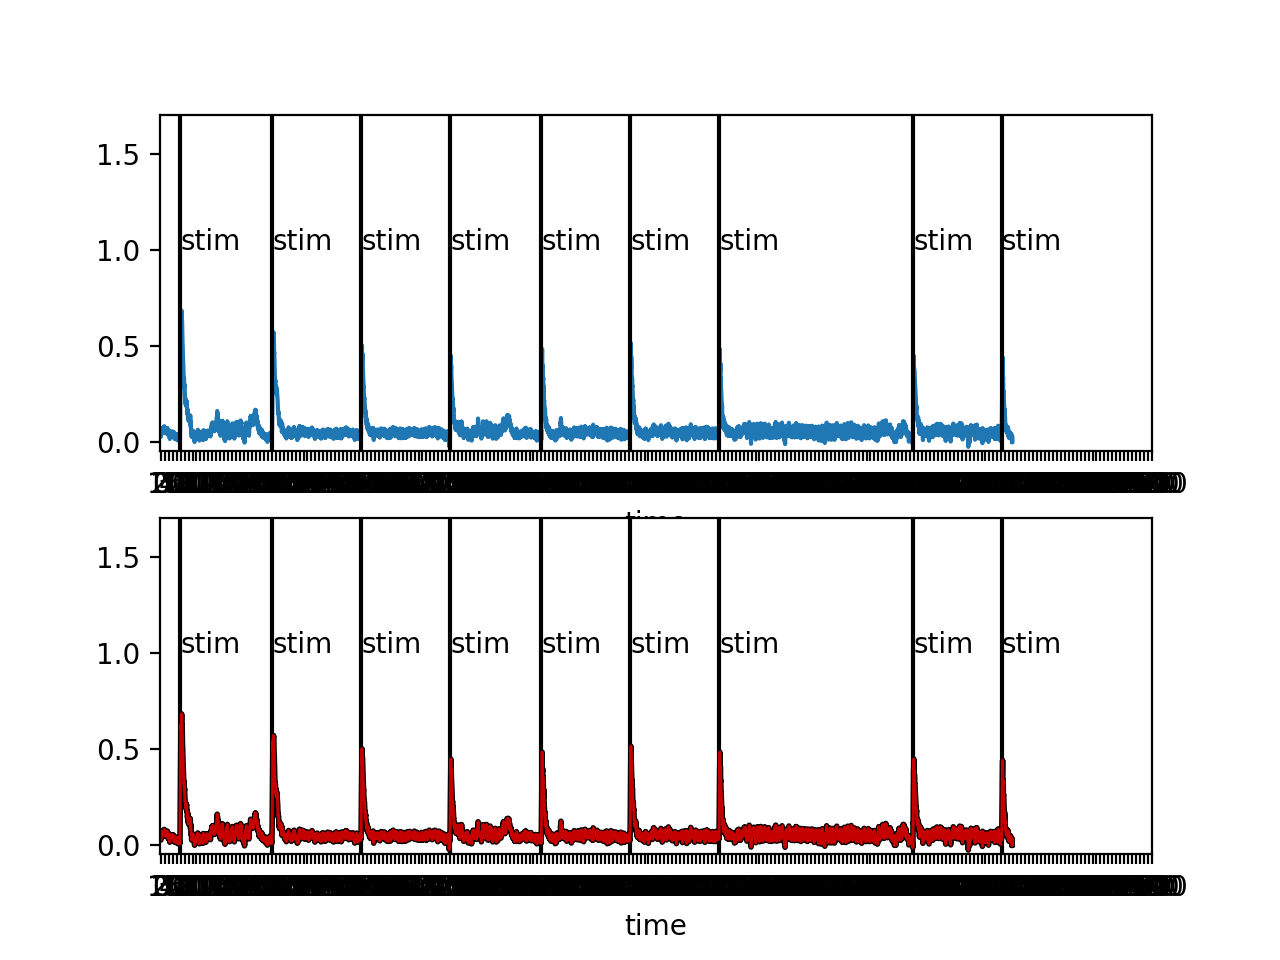

TP of stim = 48.717
TP of stim = 280.751
TP of stim = 505.412
TP of stim = 729.754
TP of stim = 959.865
TP of stim = 1183.885
TP of stim = 1408.227
TP of stim = 1897.292
TP of stim = 2121.313


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [47]:
#Define a class with sample_id, cell_type, event_name and filter_pattern
class CellTraceConfig:
    
    def __init__(self, sample_id, cell_type, event_name, filter_pattern=None):
        self.sample_id = sample_id
        self.cell_type = cell_type
        self.event_name = event_name
        self.filter_pattern = filter_pattern
        
    def get_filter_regex(self):
        filter_regex = '^{}_'.format(self.cell_type)
        if self.filter_pattern:
            filter_regex += '.*{}.*'.format(self.filter_pattern)
        return filter_regex
    
    def get_event_start_col(self):
        return '{}_start'.format(self.event_name)

    def add_event_time_points_to_plot(self, source_df, plot):
        for idx, row in source_df.iterrows():
            plot.annotate(self.event_name, xy=(row['time'], 1))
            plt.axvline(row['time'], color='k', linestyle='-')
        

def layout_plot(plot, tick_spacing=10, fov=(-2, 2500, -0.05, 1.7), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

    
#Allows to load specific samples
cell_trace_configs = [
    #CellTraceConfig('17-08-26L6-cl', 'basin', 'stim', 'A6'),
    #CellTraceConfig('17-08-23L1-cl', 'A00c', 'bw'),
    #CellTraceConfig('17-08-23L2-cl', 'A00c', 'bw'),
    #CellTraceConfig('17-08-24L1-cl', 'A00c', 'bw'),
    #CellTraceConfig('17-08-24L4-cl', 'A00c', 'bw'),
    CellTraceConfig('17-08-26L6-cl', 'A00c', 'stim', 'midL'),
    #CellTraceConfig('17-08-24L2-1-cl', 'A00c', 'bw',),
    #CellTraceConfig('17-08-24L2-2-cl', 'A00c', 'stim', 'midL')
]


all_events = [] #List of events, with raw dff data (no interpolation or other 
                #processing done at this point). Sample_id is added to the cell name. 

for ctc in cell_trace_configs:
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue
        
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells    
    
    # Cell: min/max, avg for plotting over entire time of a single sample 
    # If the avg/min/max/sdtdev/sem.. are calculated here, than the time has to be set to the index!!
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index
    
    cell_avg_df = cell_subset_df.mean(axis=1)
    cell_min_df = cell_subset_df.min(axis=1)
    cell_max_df = cell_subset_df.max(axis=1)
    # Standard deviation (distribution)
    cell_std_df = cell_subset_df.std(axis = 1,)
    #standard error of mean
    cell_sem_df = cell_subset_df.sem(axis = 1)
    # Get rows where current event is active and draw a vertical line to indicate the event in the plot.
    event_df = sample_df[sample_df.loc[:,ctc.get_event_start_col()] == 1]
    #print(list(event_df)) #prints header
    fig = plt.figure()

    # Plot all cells from sample_df(s) over entire time specified in Cell_Trace_Config.
    # Each sample gets its own plot.
    sub1 = fig.add_subplot(211)
    cell_subset_df.plot(ax=sub1)
    ctc.add_event_time_points_to_plot(event_df, sub1)
    layout_plot(sub1)

    # Avg, min, max, std-dev (single sample)
    sub2 = fig.add_subplot(212)
    ctc.add_event_time_points_to_plot(event_df, sub2)
    cell_avg_df.plot(ax=sub2, color = 'k', label = ctc.cell_type, linewidth=2)
    cell_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
    cell_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
    cell_avg_df.plot.line(yerr=cell_std_df, ax=sub2, color = 'r', alpha = 0.1)
    #plotting standard error of mean
    #cell_avg_df.plot.line(yerr=h_sem, ax=sub2, color = 'c', alpha = 0.1)
    layout_plot(sub2)
    
    # Gives the timestamp for the event_df
    for idx, row in event_df.iterrows():
        print('TP of {} ='.format(ctc.event_name), row['time'])
        
    # Extract for specific time window and align several events. Define timepoints pre and post an event (event_df). 
    # This works for single sample or multiple samples aligned 
    # Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
    # Add index and time = column
    cell_subset_df.reset_index(inplace = True) 

    # Set the window range left and right from the event
    left_half_window_size = 1.0 #in seconds
    right_half_window_size = 1.0

    # Event_df defined in pargraph before 
    windows = []
    n_behavior = 0
    for i,row in event_df.iterrows():
        n_behavior += 1
        window_start = row['time'] - left_half_window_size
        window_end = row['time'] + right_half_window_size
        
        # Get subset of rows between window_start and window_end       
        event = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
        # Normalizing the data to align on beginning of selected
        # behavior (event_df = Zero) by substracting events in window
        # around start of event of interest from start of event interest.
        # Note: using ":" in event.loc[] will select "all rows" in our window.
        event.loc[:, 'time'] = event['time'] - row['time']

        # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
        event.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), 
                     axis = 'columns', inplace = True) 

        # Rename time collum to time
        event.rename(columns={ event.columns[0]: 'time' }, inplace = True)
        all_events.append(event) # Append a list with all event
        
        
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_df = all_events.pop(0)
for right_df in all_events:
    all_df = pd.merge_ordered(all_df, right_df, on="time", how="outer")

# Resets the index as time and drops time column
all_df.index = all_df["time"]
del all_df["time"]      


In [48]:
# Data anlysis and Plotting 

# Analyse all_df (all events are aligned and merge_ordered, without further processing)
#ToDo

# Plotting all_df (all events are aligned and merge_ordered, without 
# further processing). If a dataframe with NANs is plotted, use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points

# since it is in a new block now, needs more work
#sub3 = fig.add_subplot(213)
#all_df.plot(ax=sub3, marker='+')
#layout_plot(sub3)


# Dataprocessing
# For the next step, we try two methods two normalize the data and get the timestamps 
# in synchrony between the different samples/events (1.Interpolation of some kind, 2. Binning)
        
       
# Interpolation 
# For testing purpose we use inplace  = True, otherwise create new df since we want to keep on data sets with raw data

# Linear Interpolation 
# (According to documentation it is not correct to use, because it assums the index is equally spaced)
#all_df.interpolate(method='linear', inplace=True)

# ‘Index’, ‘values’: use the actual numerical values of the index.
intpol_all_df = all_df.interpolate(method='index', inplace=True)
#print(intpol_all_df)

# Binning using slowest imaging speed as a threshold 
# threshold value 0.37799999999992906 (calculated after loading in time_data)
#Bin timepoints with threshold  
#threshold = 0.38
# So far I only found binning with intigers

#ToDo
# Analysis of processed data 
#avg, min, max
#all_df_avg = all_df.mean(axis=1)
#all_df_min = cell_subset_df.min(axis=1)
#all_df_max = cell_subset_df.max(axis=1)


# Plot of processed data
#sub4 = fig.add_subplot(414)
#all_df_avg.plot(ax=sub4, color = 'k')
#all_df_min.plot(ax=sub4, color = 'r')
#all_df_max.plot(ax=sub4, color = 'r')


The following part extract the information about behavior transition under certain limitation:
1) Find second_behavior, and extract information if the defined first_behavior happens within a max_delay.
2) Find first_behavior, and extract information if the defined second_behavior happens within a max_delay.
3) Find second_behavior, and extract information if the defined first_behavior and third_behavior 
   happens within a max_delay.
4) Find first_behavior, and extract information if the same second_behavior happens within a max_delay. Note: So far no overlap cases detected. Code for overlap cases could not be verified.

In [69]:
class PreBehaviorTransition:
    
    def __init__(self, sample_id, pre_event, event, max_delay=0):
        self.sample_id = sample_id
        self.pre_event = pre_event
        self.event = event
        self.max_delay = max_delay

def find_behavior_after(sample_id, sample_df, first_event, second_event, max_delay=0):
    """For the data frame of a single sample <df>, find all behaviors
    of type <second_event> that follow the event <first_event>,
    separated by <max_delay> time. The start of <first_event> is expected
    to happen strictly before the start of <second_event>. The end time
    of <first_event> however can overlap with the start time of <second_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The end time of <first_event> can be before, at or after the
    end of <second_event>.
    
    TODO: If <first_event> and <second_event> are the same type of behavior,
    overlaps have to be taken into account to match start and end times
    to the correct event.
    """
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    first_event_overlap_col = '{}_overlap'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
    for i, row in sample_df.iterrows():
        # Look for end of first behavior and remember its time.
        if row[first_event_start_col]:
            first_event_start_time = row['time']
        if row[first_event_end_col] and not row[first_event_overlap_col]:
            first_event_end_time = row['time']
        if row[second_event_start_col]:
            second_event_start_time = row['time']
        if row[second_event_end_col]:
            second_event_end_time = row['time']
        
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time, second_event_end_time):
            continue
            
        #NR
        if first_event_start_time > second_event_start_time:
            continue
            
        if abs(first_event_start_time - second_event_start_time) < 0.00001:
            print('{}: start time (first) event {} and start time of (second) event {} are the same: {}'.format(
                sample_id, first_event, second_event, first_event_start_time))

        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed.
        if (second_event_start_time - first_event_end_time) <= max_delay:
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time,
                'second_event_end': second_event_end_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
            
    return results

behavior_transitions = [
    PreBehaviorTransition('17-08-26L6-cl', 'stim', 'fw', 1),
]

found_transitions = []
for bt in behavior_transitions:
    sample_df = sample_data.get(bt.sample_id)
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_after(bt.sample_id, sample_df, bt.pre_event, bt.event, bt.max_delay)
    found_transitions.append(transitions)

print(found_transitions)

[[{'sample_id': '17-08-26L6-cl', 'first_event_start': 48.717, 'first_event_end': 50.64, 'second_event_start': 50.961, 'second_event_end': 55.127}, {'sample_id': '17-08-26L6-cl', 'first_event_start': 280.751, 'first_event_end': 282.673, 'second_event_start': 282.673, 'second_event_end': 240.369}]]


In [66]:
class PostBehaviorTransition:
    
    def __init__(self, sample_id, event, post_event, max_delay=0):
        self.sample_id = sample_id
        self.post_event = post_event
        self.event = event
        self.max_delay = max_delay

def find_behavior_before(sample_id, sample_df, first_event, second_event, max_delay=0):
    """For the data frame of a single sample <df>, find all behaviors
    of type <first_event> that is followed by the event <second_event>,
    separated by <max_delay> time. The end of <second_event> is expected
    to happen strictly after the end of <first_event>. The start time
    of <second_event> however can overlap with the end time of <first_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The start time of <second_event> can be before, at or after the
    end of <first_event>.
    
    TODO: If <first_event> and <second_event> are the same type of behavior,
    overlaps have to be taken into account to match start and end times
    to the correct event.
    """
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    second_event_overlap_col = '{}_overlap'.format(second_event)
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
    for i, row in sample_df.iterrows():
        # Look for start of second behavior and remember its time.
        if row[second_event_start_col] and not row[second_event_overlap_col]:
            second_event_start_time = row['time']
        if row[first_event_end_col]:
            first_event_end_time = row['time']
        if row[first_event_start_col]:
            first_event_start_time = row['time']
        
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time):
            continue
        
        #NR
        if first_event_start_time > second_event_start_time:
            continue
        
        if abs(first_event_start_time - second_event_start_time) < 0.00001:
            print('{}: start time (first) event {} and start time of (second) event {} are the same: {}'.format(
                sample_id, first_event, second_event, first_event_start_time))

        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed.
        if (second_event_start_time - first_event_end_time) <= max_delay:
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
            
    return results

behavior_transitions = [
    PostBehaviorTransition('17-08-26L6-cl', 'stim', 'fw', 10),
]

found_transitions = []
for bt in behavior_transitions:
    sample_df = sample_data.get(bt.sample_id)
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_before(bt.sample_id, sample_df, bt.event, bt.post_event, bt.max_delay)
    found_transitions.append(transitions)

print(found_transitions)

[[{'sample_id': '17-08-26L6-cl', 'first_event_start': 48.717, 'first_event_end': 50.64, 'second_event_start': 50.961}, {'sample_id': '17-08-26L6-cl', 'first_event_start': 280.751, 'first_event_end': 282.673, 'second_event_start': 282.673}, {'sample_id': '17-08-26L6-cl', 'first_event_start': 1897.292, 'first_event_end': 1899.214, 'second_event_start': 1900.496}]]


In [67]:
class BehaviorTransition:
    
    def __init__(self, sample_id, pre_event, event, post_event,
                 pre_max_delay=0, post_max_delay=0):
        self.sample_id = sample_id
        self.pre_event = pre_event
        self.event = event
        self.post_event = post_event
        self.pre_max_delay = pre_max_delay
        self.post_max_delay = post_max_delay

def find_behavior_between(sample_id, sample_df, first_event, second_event,
                          third_event, pre_max_delay=0, post_max_delay=0):
    """For the data frame of a single sample <df>, find all behaviors
    of type <second_event> that a) follows the event <first_event>,
    separated by <pre_max_delay> time. The start of <first_event> is expected
    to happen strictly before the start of <second_event>. The end time
    of <first_event> however can overlap with the start time of <second_event>.
    In this case, the time difference is negative, and still smaller than
    <pre_max_delay>. The end time of <first_event> can be before, at or after the
    end of <second_event>. And b) the behavior <second_event> is followed by the
    event <third_event>, separated by <post_max_delay> time. The end of
    <third_event> is expected to happen strictly after the end of <second_event>.
    The start time of <third_event> however can overlap with the end time of
    <second_event>. In this case, the time difference is negative, and still
    smaller than <post_max_delay>. The start time of <third_event> can be before,
    at or after the end of <second_event>.
    
    The start of <first_event> is expected to happen strictly before the start
    of <third_event>. Apart from this, both <first_event> and <third_event> can
    overlap.
    
    TODO: handle overlaps when behavior types are the same.
    """
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    first_event_overlap_col = '{}_overlap'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    third_event_start_col = '{}_start'.format(third_event)
    third_event_end_col = '{}_end'.format(third_event)
    third_event_overlap_col = '{}_overlap'.format(third_event)
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    third_event_start_time = None
    third_event_end_time = None

    for i, row in sample_df.iterrows():
        # Look for behaviors and remember its time.
        if row[first_event_start_col]:
            first_event_start_time = row['time']
        if row[first_event_end_col] and not row[first_event_overlap_col]:
            first_event_end_time = row['time']
        if row[second_event_start_col]:
            second_event_start_time = row['time']
        if row[second_event_end_col]:
            second_event_end_time = row['time']
        if row[third_event_start_col] and not row[third_event_overlap_col]:
            third_event_start_time = row['time']
            
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_end_time, second_event_start_time,
                    second_event_end_time, third_event_start_time):
            continue
            
        #NR
        if first_event_start_time > second_event_start_time:
            continue
            
        if abs(first_event_start_time - second_event_start_time) < 0.00001:
            print('{}: start time (first) event {} and start time of (second) event {} are the same: {}'.format(
                sample_id, first_event, second_event, first_event_start_time))
        if abs(second_event_start_time - third_event_start_time) < 0.00001:
            print('{}: start time (second) event {} and start time of (third) event {} are the same: {}'.format(
                sample_id, second_event, third_event, second_event_start_time))

        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed.
        if (second_event_start_time - first_event_end_time) <= pre_max_delay \
                and (third_event_start_time - second_event_end_time) <= post_max_delay:
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time,
                'second_event_end': second_event_end_time,
                'third_event_start': third_event_start_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
        third_event_start_time = None
        third_event_end_time = None

    return results

behavior_transitions = [
    BehaviorTransition('17-08-26L6-cl', 'quiet', 'stim', 'fw', 1000, 1000),
]

found_transitions = []
for bt in behavior_transitions:
    sample_df = sample_data.get(bt.sample_id)
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_between(bt.sample_id, sample_df, bt.pre_event,
                                        bt.event, bt.post_event, bt.pre_max_delay,
                                        bt.post_max_delay)
    found_transitions.append(transitions)

print(found_transitions)

[[{'sample_id': '17-08-26L6-cl', 'first_event_start': 0.0, 'first_event_end': 48.4, 'second_event_start': 48.717, 'second_event_end': 50.64, 'third_event_start': 50.961}, {'sample_id': '17-08-26L6-cl', 'first_event_start': 243.894, 'first_event_end': 280.431, 'second_event_start': 280.751, 'second_event_end': 282.673, 'third_event_start': 282.673}, {'sample_id': '17-08-26L6-cl', 'first_event_start': 354.142, 'first_event_end': 505.094, 'second_event_start': 505.412, 'second_event_end': 507.335, 'third_event_start': 288.442}, {'sample_id': '17-08-26L6-cl', 'first_event_start': 879.422, 'first_event_end': 959.546, 'second_event_start': 959.865, 'second_event_end': 731.677, 'third_event_start': 867.243}, {'sample_id': '17-08-26L6-cl', 'first_event_start': 1074.599, 'first_event_end': 1183.567, 'second_event_start': 1183.885, 'second_event_end': 961.787, 'third_event_start': 1006.335}, {'sample_id': '17-08-26L6-cl', 'first_event_start': 1874.857, 'first_event_end': 1896.973, 'second_event_

In [64]:
# All behavior_transitions, which were considered before assume that subsequent behaviors 
# are not the same. For same pairwise (2 behavior), we need to access also the data, when 
# the behaviors are same

class SamePairBehaviorTransition:
    
    def __init__(self, sample_id, pre_event, event, max_delay=0):
        self.sample_id = sample_id
        self.pre_event = pre_event
        self.event = event
        self.max_delay = max_delay

def find_behavior_next(sample_id, sample_df, first_event, second_event, max_delay=0):
    """For the data frame of a single sample <df>, find all behaviors
    of type <first_event> that will be followed by the same event <second_event>,
    separated by <max_delay> time. The start of <first_event> is expected
    to happen strictly before the start of <second_event>. The end time
    of <first_event> however can overlap with the start time of <second_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The end time of <first_event> can be before, at or after the
    end of <second_event>.
    
    If <first_event> and <second_event> are the same type of behavior,
    overlaps have to be taken into account differently to match start and end times
    to the correct event. During iteration for one loop, we have to exclude the 
    fact that the first_event == second_event.
    """
    
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    first_event_overlap_col = '{}_overlap'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    second_event_overlap_col = '{}_overlap'.format(second_event) 
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
    # Check for overlap between the same behaviors (print index, where 'True') and use
    # it as a check that there is not this error in the behavior data
    #print(sample_df.index[sample_df['turn_overlap']].tolist())
    
    # Note: The overlap statement was removed. This part has to be 
    # checked if overlapping events are found in the data
    for i, row in sample_df.iterrows():
        # Look for start of first behavior and remember its time.
        if row[first_event_start_col]:
            first_event_start_time = row['time']
        if row[first_event_end_col]: 
            first_event_end_time = row['time']
        if row[second_event_start_col]:
            second_event_start_time = row['time']
        if row[second_event_end_col]:
            second_event_end_time = row['time']
        
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time, second_event_end_time):
            continue
        
        #NR
        if first_event_start_time > second_event_start_time:
            continue


        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed. During iteration the first_event == second_event. 
        if (second_event_start_time == first_event_end_time): #NR
            continue
        if (second_event_start_time - first_event_end_time) <= max_delay:
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time,
                'second_event_end': second_event_end_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
            
    return results

behavior_transitions = [
    SamePairBehaviorTransition('17-08-26L4-cl', 'fw', 'stim', 10),
]

found_transitions = []
for bt in behavior_transitions:
    sample_df = sample_data.get(bt.sample_id)
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_next(bt.sample_id, sample_df, bt.pre_event, bt.event, bt.max_delay)
    found_transitions.append(transitions)

print(found_transitions)

[[{'sample_id': '17-08-26L4-cl', 'first_event_start': 442.388, 'first_event_end': 445.99, 'second_event_start': 446.315, 'second_event_end': 209.416}, {'sample_id': '17-08-26L4-cl', 'first_event_start': 683.213, 'first_event_end': 686.158, 'second_event_start': 687.794, 'second_event_end': 448.277}, {'sample_id': '17-08-26L4-cl', 'first_event_start': 919.785, 'first_event_end': 922.402, 'second_event_start': 924.038, 'second_event_end': 689.758}, {'sample_id': '17-08-26L4-cl', 'first_event_start': 1322.578, 'first_event_end': 1327.159, 'second_event_start': 1328.468, 'second_event_end': 926.002}, {'sample_id': '17-08-26L4-cl', 'first_event_start': 1559.149, 'first_event_end': 1561.113, 'second_event_start': 1562.422, 'second_event_end': 1330.431}, {'sample_id': '17-08-26L4-cl', 'first_event_start': 2188.043, 'first_event_end': 2191.643, 'second_event_start': 2192.297, 'second_event_end': 1564.384}]]


In [ ]:
# test delay


In [60]:
class PostBehaviorTransition:
    
    def __init__(self, sample_id, event, post_event, max_delay=0):
        self.sample_id = sample_id
        self.post_event = post_event
        self.event = event
        self.max_delay = max_delay

def find_behavior_before(sample_id, sample_df, first_event, second_event, max_delay=0):
    """For the data frame of a single sample <df>, find all behaviors
    of type <first_event> that is followed by the event <second_event>,
    separated by <max_delay> time. The end of <second_event> is expected
    to happen strictly after the end of <first_event>. The start time
    of <second_event> however can overlap with the end time of <first_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The start time of <second_event> can be before, at or after the
    end of <first_event>.
    
    TODO: If <first_event> and <second_event> are the same type of behavior,
    overlaps have to be taken into account to match start and end times
    to the correct event.
    """
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    second_event_overlap_col = '{}_overlap'.format(second_event)
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
    for i, row in sample_df.iterrows():
        # Look for start of second behavior and remember its time.
        if row[second_event_start_col] and not row[second_event_overlap_col]:
            second_event_start_time = row['time']
        if row[first_event_end_col]:
            first_event_end_time = row['time']
        if row[first_event_start_col]:
            first_event_start_time = row['time']
        
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time):
            continue
        #NR
        if first_event_start_time > second_event_start_time:
            continue
        
        if abs(first_event_start_time - second_event_start_time) < 0.00001:
            print('{}: start time (first) event {} and start time of (second) event {} are the same: {}'.format(
                sample_id, first_event, second_event, first_event_start_time))

        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed.
        if (second_event_start_time - first_event_end_time) <= max_delay:
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time,
                'second_event_end': second_event_end_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
            
    return results

behavior_transitions = [
    PostBehaviorTransition('17-08-26L6-cl', 'bw', 'fw', 5),
]

found_transitions = []
for bt in behavior_transitions:
    sample_df = sample_data.get(bt.sample_id)
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_before(bt.sample_id, sample_df, bt.event, bt.post_event, bt.max_delay)
    found_transitions.append(transitions)

print(found_transitions)

[[]]
